# Scraping Trustpilot

## Imports

### Packages

In [51]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import pandas as pd
import re
import requests
import time
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from datetime import datetime
from functools import partial
from tqdm import tqdm

In [52]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/onyxia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Scraping

### Variables globales

In [53]:
url_trustpilot = 'https://fr.trustpilot.com/review/'

In [54]:
headers = {
    'User-Agent': 'Antoine Palazzolo - INSEE - Collect data to organize a code exercise',
    'From': 'antoine.palazzolo@insee.fr'
}

In [55]:
target_companies = ['hellofresh.fr',
                    'auroremarket.fr',
                    'smartfooding.com',
                    'foodette.fr',
                    'ollca.com',
                    'deligreens.com',
                    'kitchentrotter.com']

In [56]:
do_scraping = False  # True pour refaire tourner le scraping, False pour importer la dernière version depuis s3

### Fonctions

#### Scraping one review

In [57]:
def get_note_review(review):
    
    try:
        texte_note = review.find(
            'div', {'class':'star-rating_starRating__4rrcf star-rating_medium__iN6Ty'}
        ).find('img', alt=True)['alt']
        note = int(texte_note[5])  # texte_note = "Noté x étoiles sur 5"
        return note

    except:
        return "Not found"

In [58]:
def get_time_review(review):
    
    try:
        str_date = review.find(
            'div', {'class':'typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_datesWrapper__RCEKH'}
        ).find('time')['datetime']
        date = datetime.strptime(str_date, "%Y-%m-%dT%H:%M:%S.%fZ")  # str_date = 'YYYY-MM-DDThh:mm:ss.000Z'
        return date

    except:
        return "Not found"

In [59]:
def get_title_review(review):
    
    try:
        title = review.find(
            'h2', {'class':'typography_heading-s__f7029 typography_appearance-default__AAY17'}
        ).text
        return title

    except:
        return "Not found"

In [60]:
def get_comment_review(review):
    
    try:
        text = review.find(
            'p', {'class':'typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn'}
        ).text # Les balises <br> sont supprimées, on va donc forcer des espaces après les points
        text = re.sub(' +', ' ', text.replace('.', '. '))
        return text

    except:
        return "Not found"

#### Scraping one company

In [61]:
def get_nb_pages_reviews(url_company):

    time.sleep(1)
    request_text = requests.get(url_company, headers=headers).text
    soup = BeautifulSoup(request_text, 'html.parser')

    try:
        boutons_pages = soup.find(
            'div', {'class':'styles_pagination__6VmQv'}
        ).find_all(
            'span', {'class':'typography_heading-xxs__QKBS8 typography_appearance-inherit__D7XqR typography_disableResponsiveSizing__OuNP7'}
        )
        last_page = int(boutons_pages[-2].text)  # Dernier bouton = "Page Suivante"
        return last_page

    except:
        return 0

In [62]:
def scraping_one_company(company, limit_pages=False):

    print(company)
    url_company = url_trustpilot+company
    nb_pages = get_nb_pages_reviews(url_company)
    if limit_pages and nb_pages > 2:
        nb_pages = 2
    notes, times, titles, comments = [], [], [], []

    for page in tqdm(range(1, nb_pages+1)):

        time.sleep(1)
        url_page = url_company + '?page=' + str(page)
        
        try:
            request_text = requests.get(url_page, headers=headers).text
            soup = BeautifulSoup(request_text, 'html.parser')
            reviews = soup.find_all(
                'div', {'class':'styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ'}
            )
        except:
            reviews = []

        notes.extend(list(map(get_note_review, reviews)))
        times.extend(list(map(get_time_review, reviews)))
        titles.extend(list(map(get_title_review, reviews)))
        comments.extend(list(map(get_comment_review, reviews)))

    df_reviews = pd.DataFrame({
        'note': notes,
        'date': times,
        'title': titles,
        'comment': comments
    })

    return df_reviews


#### Scraping all companies

In [63]:
def scraping_all_companies(companies_list=target_companies,
                           limit_pages=False):

    reviews_companies = list(map(
        partial(scraping_one_company, limit_pages=limit_pages),
                companies_list
    ))
    n = len(companies_list)
    for i in range(n):
        reviews_companies[i]['company'] = companies_list[i]
    df_all_reviews = pd.concat(reviews_companies)
    
    return df_all_reviews

### Mise en pratique

In [64]:
if do_scraping:
    df_all_reviews = scraping_all_companies(
        # limit_pages=True
    )
else:
    os.system(f"mc cp s3/projet-funathon/2023/sujet5/reviews_takeaway.parquet reviews_takeaway.parquet")
    df_all_reviews = pd.read_parquet("reviews_takeaway.parquet")

`s3/projet-funathon/2023/sujet5/reviews_takeaway.parquet` -> `reviews_takeaway.parquet`
Total: 0 B, Transferred: 2.77 MiB, Speed: 13.03 MiB/s


In [65]:
print(f'{len(df_all_reviews)} avis réunis')

df_all_reviews.head()

20438 avis réunis


,note,date,title,comment,company
0,3,2023-05-16 14:07:58,Des produits manquants pour une…,"Des produits manquants pour une recette, conta...",hellofresh.fr
1,5,2023-05-16 13:08:14,Facile et pratique,Les box hellofresh nous facilitent le quotidie...,hellofresh.fr
2,4,2023-05-14 20:08:49,Super idée recettes délicieuses.,Super idée recettes délicieuses. Tous les ingr...,hellofresh.fr
3,1,2023-05-16 19:33:36,Service de livraison incompétent !,"Jusqu’à présent satisfait de la marque, mais u...",hellofresh.fr
4,1,2023-05-15 17:02:04,Expérience d'achat inacceptable,Expérience d'achat inacceptable. Une chaîne du...,hellofresh.fr


In [66]:
df_problemes = df_all_reviews[df_all_reviews.apply(lambda row: row.str.contains('Not found').any(), axis=1)]
df_problemes

,note,date,title,comment,company
176,5,2023-05-16 13:57:25,Je recommande c'est top,Not found,hellofresh.fr
180,1,2023-05-13 11:01:50,Colis toujours pas livré,Not found,hellofresh.fr
189,3,2023-05-09 00:03:41,Quantité beaucoup trop peu,Not found,hellofresh.fr
192,5,2023-05-10 11:07:27,Parfait nous adorons le concept,Not found,hellofresh.fr
194,5,2023-05-10 10:44:19,Très bonne recette et facile,Not found,hellofresh.fr
...,...,...,...,...,...
20251,1,2023-01-10 11:42:23,grosse Arnaque,Not found,kitchentrotter.com
20252,1,2020-04-01 08:20:29,Une bande d'escrocs via cdiscount !!!,Not found,kitchentrotter.com
20253,1,2021-03-02 10:58:32,je porte plainte !!!!,Not found,kitchentrotter.com
20362,1,2019-04-12 13:51:56,Je ne me suis jamais inscrite!!!,Not found,kitchentrotter.com


In [67]:
df_problemes[df_problemes['comment'] != "Not found"]

,note,date,title,comment,company


In [68]:
df_all_reviews.to_parquet("reviews_takeaway.parquet", index=False)

In [69]:
os.system(f"mc cp reviews_takeaway.parquet s3/projet-funathon/2023/sujet5/reviews_takeaway.parquet")

`/home/onyxia/work/funathon2023_sujet5/reviews_takeaway.parquet` -> `s3/projet-funathon/2023/sujet5/reviews_takeaway.parquet`
Total: 0 B, Transferred: 2.77 MiB, Speed: 4.35 MiB/s


0

## Utilisation des avis

### Regarder les notes

(array([ 1764.,   710.,  1780.,  4830., 11354.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <BarContainer object of 5 artists>)

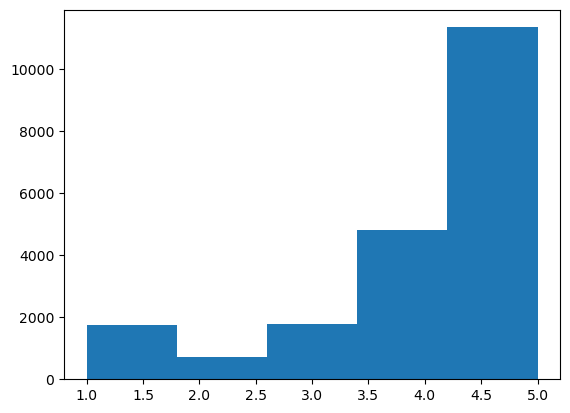

In [70]:
plt.hist(df_all_reviews['note'], bins=5)

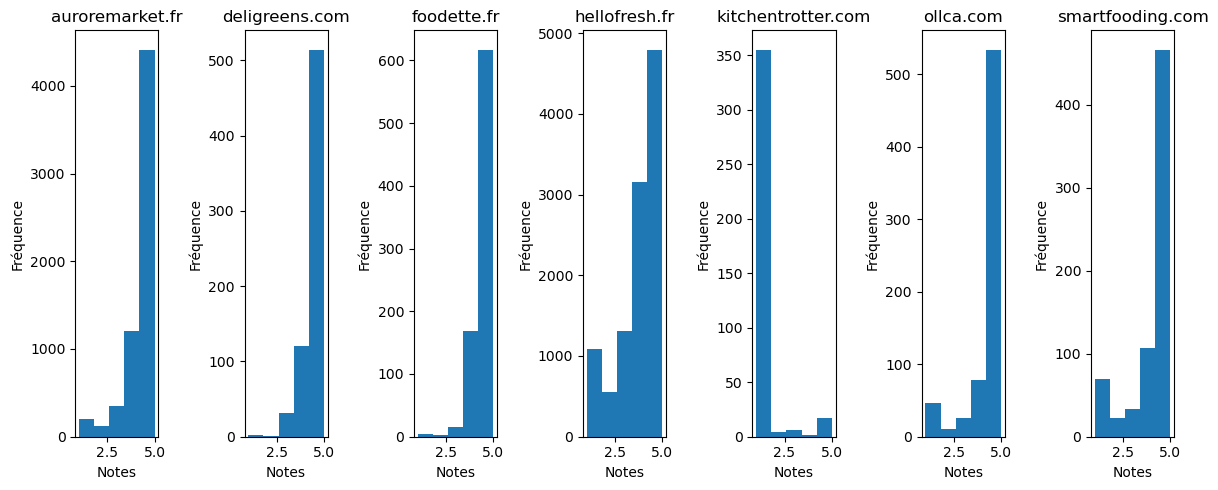

In [71]:
df_all_reviews_by_company = df_all_reviews.groupby('company')['note'].apply(list)

# Créer une grille de sous-graphiques
n_companies = len(df_all_reviews_by_company)
fig, axes = plt.subplots(nrows=1, ncols=n_companies, figsize=(12, 5))

# Parcourir les données et créer un histogramme pour chaque entreprise sur un sous-graphique distinct
for i, (company, notes) in enumerate(df_all_reviews_by_company.items()):
    ax = axes[i]  # Sélectionner le sous-graphique correspondant
    ax.hist(notes, bins=5)  # Créer l'histogramme
    ax.set_xlabel('Notes')  # Définir l'étiquette de l'axe x pour le sous-graphique
    ax.set_ylabel('Fréquence')  # Définir l'étiquette de l'axe y pour le sous-graphique
    ax.set_title(company)  # Définir le titre du sous-graphique

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

### Regarder les commentaires

#### Longueurs des commentaires

In [72]:
df_all_reviews['len_title'] = df_all_reviews['title'].str.len()
df_all_reviews['len_comment'] = df_all_reviews['comment'].str.len()

(array([3.014e+03, 5.123e+03, 4.028e+03, 7.406e+03, 4.700e+02, 1.990e+02,
        1.100e+02, 3.500e+01, 2.000e+01, 8.000e+00, 5.000e+00, 6.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00]),
 array([  2. ,  11.9,  21.8,  31.7,  41.6,  51.5,  61.4,  71.3,  81.2,
         91.1, 101. , 110.9, 120.8, 130.7, 140.6, 150.5, 160.4, 170.3,
        180.2, 190.1, 200. ]),
 <BarContainer object of 20 artists>)

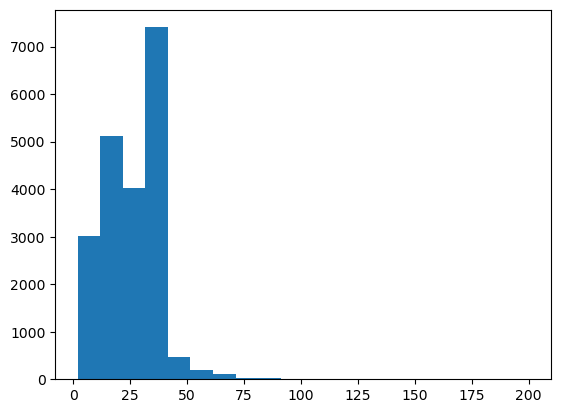

In [73]:
plt.hist(df_all_reviews['len_title'], bins=20)

(array([1.5351e+04, 3.7000e+03, 8.5500e+02, 2.8200e+02, 1.2100e+02,
        5.0000e+01, 2.7000e+01, 2.0000e+01, 1.2000e+01, 7.0000e+00,
        5.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   9. ,  248.8,  488.6,  728.4,  968.2, 1208. , 1447.8, 1687.6,
        1927.4, 2167.2, 2407. , 2646.8, 2886.6, 3126.4, 3366.2, 3606. ,
        3845.8, 4085.6, 4325.4, 4565.2, 4805. ]),
 <BarContainer object of 20 artists>)

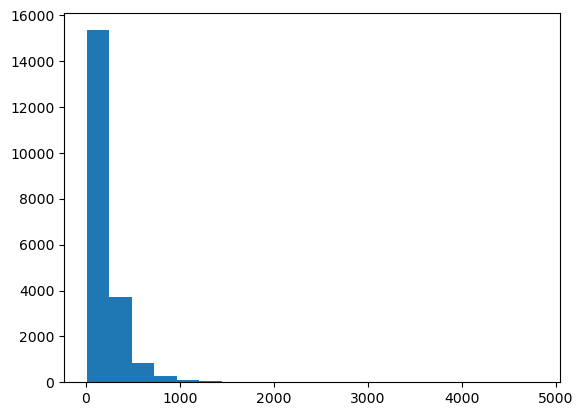

In [74]:
plt.hist(df_all_reviews['len_comment'], bins=20)

(array([3315., 4635., 3324., 2389., 1716., 1232.,  976.,  663.,  487.,
         381.,  239.,  194.,  179.,  125.,   83.,   86.,   61.,   54.,
          34.,   37.,   34.,   25.,   21.,   17.,   14.,   11.,   12.,
           5.,   10.,   13.]),
 array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
         450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
         900.,  950., 1000., 1050., 1100., 1150., 1200., 1250., 1300.,
        1350., 1400., 1450., 1500.]),
 <BarContainer object of 30 artists>)

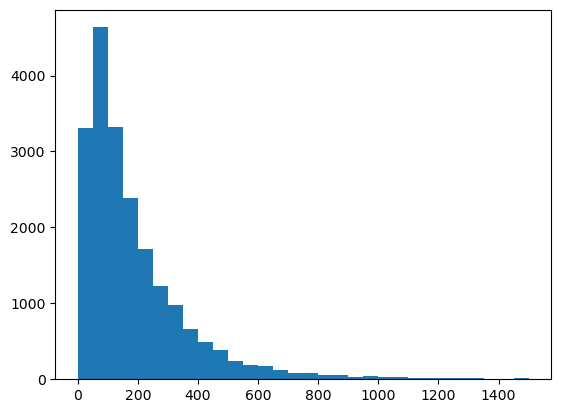

In [75]:
plt.hist(df_all_reviews['len_comment'], bins=30, range=(0,1500))

#### Nuage de mots

In [76]:
stopwords_fr = set(stopwords.words('french'))

# Ajouter les mots "not" et "found" à la liste des stopwords
stopwords_fr.update(["not", "found"])

# Ajouter manuellement les observations inintéressantes
stopwords_fr.update(["c'est", "j'ai", "donc"])

In [77]:
# Concaténer tous les commentaires en une seule chaîne de caractères
all_comments = ' '.join(df_all_reviews['comment'])

# Tokenization des commentaires en mots individuels
tokens = word_tokenize(all_comments)

# Filtrer les mots avec les stopwords en français
filtered_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_fr]

In [78]:
# Créer un nuage de mots avec les mots filtrés
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

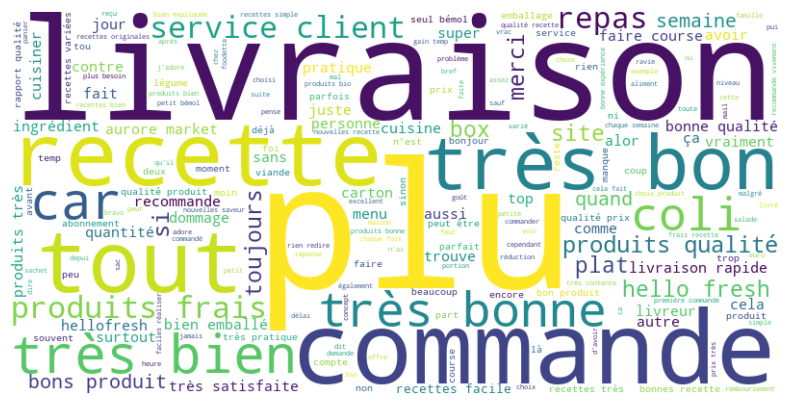

In [79]:
# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Créer un nuage de mots pour chaque valeur de 'company'
for company in target_companies:
    # Filtrer les commentaires pour la valeur de 'company' spécifique
    comments = df_all_reviews[df_all_reviews['company'] == company]['comment']
    
    # Concaténer tous les commentaires en une seule chaîne de caractères
    all_comments = ' '.join(comments)

    # Tokenization des commentaires en mots individuels
    tokens = word_tokenize(all_comments)

    # Filtrer les mots avec les stopwords en français
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_fr]

    # Créer un nuage de mots avec les mots filtrés
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

    # Afficher le nuage de mots avec le nom de la société
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(company)
    plt.axis('off')
    plt.show()